# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB//xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example
%matplotlib inline

In [282]:
def plot_lightcurve(tus, start=None, stop=None):
  # Convert trigger times from seconds to minutes
     
    if start and stop != None:
        # Create a histogram of the trigger times
        plt.hist(tus, bins=100, range=(start, stop))
    else:
        plt.hist(tus, bins=100)
    # Set the x-axis label
    plt.xlabel('Time (s)')

    # Set the y-axis label
    plt.ylabel('Number of triggers')

    # Show the plot
    plt.show()

# Notes
    DISCREPENCY FOUND FOR ASIM DATA!
    HARVEST DATA MATLAB SCRIPT OUTPUTS BAD FILE. --> Need to run the function again to see if the same error occurs.
    ---> GENERATE NEW ASIM FILES

    TODO:
    ---------
    1)
    -import KW LC and plot the selected intervals that are found in the fits files OK! 
        >> unable to use 2ms LC. Have only 2ms data from -0.512 to 0.512, which doesn't capture the main burst
    -import new ASIM LC 
    -import fermi LC OK!
    
    2)
    --> CC all the three LCs: Need 2ms KW lc to do the CC!
    - estimation of background
    - shift ASIM/FERMI LC into KW ref frame
    - step plot all three in same plot
    
    3) 
    - generate fits files for ASIM & FEMRI
    
    4)
    -Load into xspec
    
    
    
    
    NEWEST DATA SHOW A GOOD FIT AND ACCEPTIBLE NORM. CONST!

In [2]:
binsize = 0.016 #s

# KW

In [25]:
#importing KW LC

kw_fn = 'GRB210619B_16ms.txt'
kw_df = pd.read_csv(kw_lc_path+kw_fn,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float32), kw_df["Tf"].to_numpy(dtype=np.float32),kw_df["G1"].to_numpy(dtype=np.float32), kw_df["G2"].to_numpy(dtype=np.float32), kw_df["G3"].to_numpy(dtype=np.float32)
kw_df.head()

,Ti,Tf,G1,G2,G3
0,-0.512,-0.496,20.12,6.02,2.01
1,-0.496,-0.480,15.07,3.01,2.01
2,-0.480,-0.464,23.12,3.01,1.00
3,-0.464,-0.448,22.17,7.03,6.03
4,-0.448,-0.432,20.11,5.01,2.01


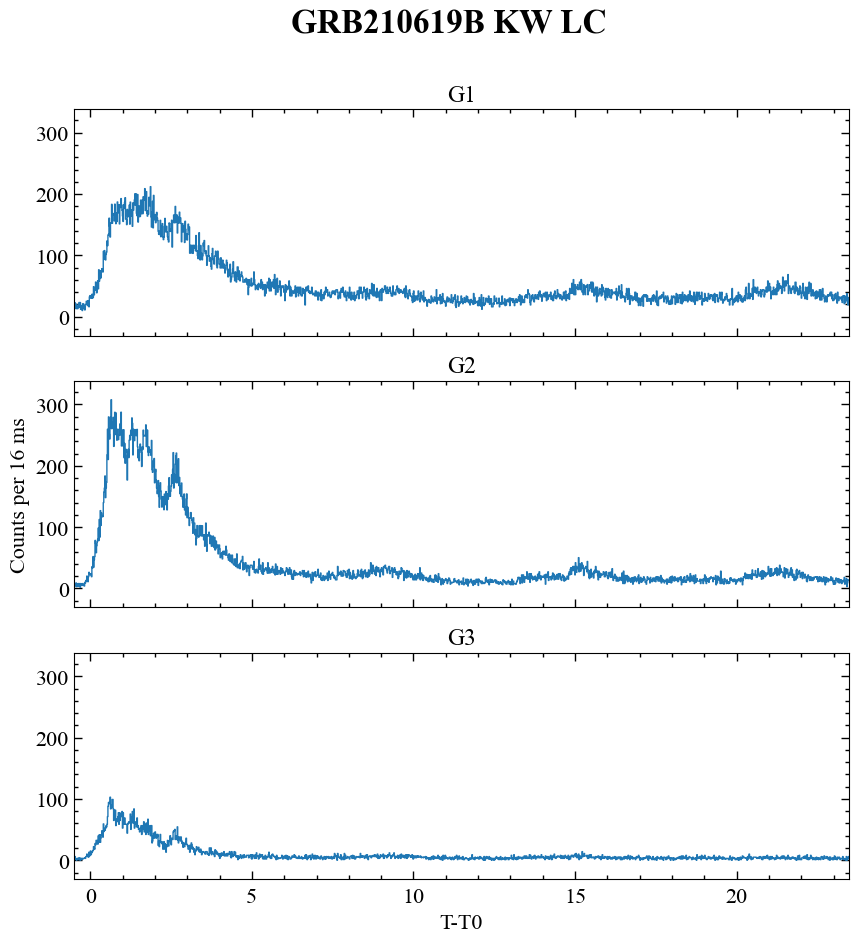

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True, sharex=True)

# Plot the data for 'G1' in the first subplot
axs[0].step(x=kw_bin_lo[:1500],y=G1[:1500],where='pre')
axs[0].set_title('G1')

# Plot the data for 'G2' in the second subplot
axs[1].step(x=kw_bin_lo[:1500],y=G2[:1500],where='pre')
axs[1].set_title('G2')
axs[1].set_ylabel('Counts per 16 ms')

# Plot the data for 'G3' in the third subplot
axs[2].step(x=kw_bin_lo[:1500],y=G3[:1500],where='pre')
axs[2].set_title('G3')

plt.xlabel('T-T0')
plt.suptitle('GRB210619B KW LC', fontsize=24, fontweight='bold')
#plt.savefig('GRB210619B_KW_LC.png',dpi=350)
plt.show()


In [27]:
kw_dt = np.round(np.diff(kw_bin_lo[:1500]),3)
np.all(kw_dt==binsize)

True

In [28]:
jx = np.searchsorted(kw_bin_lo,5) #cutting the LC at 5s
bins = np.append(kw_bin_lo[:jx],kw_bin_hi[jx]) #setting bins
G1,G2,G3 = G1[:jx],G2[:jx],G3[:jx]

# ASIM
    
    
    GENERAL LOADING OF DATA
    ------------------------------------------------------
    David Sarria's datafiles:
    
    -check if ref. time is '2021-06-19T23:59:24.915' calculated for the very first trigger
    -Removed valleys manually
    -removed safety time triggers
    -after filtering df by adr and tus, tus array for each adr is monotonically increasing
    
    
    Andrey's datafiles:
    Same LC as before, coundn't see any difference in the count rate at the peak
    
    
    
    SMALL INTERVAL T0+0.512s --> T0+0.786s 
    ------------------------------------------------------
    -Safety time:  0.002 % removed
    
    
    LARGER INTERVAL T0 --> 2.048s
    ------------------------------------------------------
    ASIM starts at ~T0-0.4s and ends at ~T0+4s. and +15s (total) 
    
    
    
    CC
    ------------------------------------------------------
    
    -eye balling:      -0.600 s
    -eye balling + CC: -0.584 s
    -ToF:              -0.623s
    -FERMI:            -0.576 s (F ref. frame)
    
    Thats 37% difference of the exposure: (0.623-0.528)/(0.768-0.512)*100
    --> Have to make it right
    
    >> eyeballing + CC seems to be the best time lagg for ASIM
    >> tlagg_asim -0.584 s
    
    
    
    
    Background
    ------------------------------------------------------
    -Applying bak file from before to test
    
    
    Need background data. Too short of a background the original file
    -Connect to server to check for background trigger 

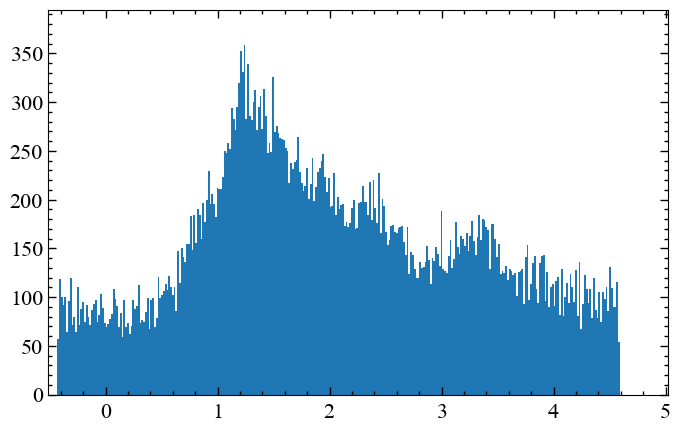

In [29]:
df_asim = pd.read_csv(mat_path_andrey+'GRB210619B.csv')
#working with [s]

tlagg = 0 #checked CC
df_asim['tus'] /= 1e6
df_asim['tus'] += tlagg
tus = df_asim['tus'].to_numpy(dtype=np.float64)
plt.hist(tus,bins=bins)
#plt.vlines(x=-0.0293,ymin=0,ymax=50,color='r')
plt.show()

In [30]:
#make adr array
T0 = datetime.fromisoformat('2021-06-19T23:59:25.494265') #cottected_datetime_level1
df_asim = make_adr(df_asim)
df_asim.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_asim.drop(df_asim[df_asim['typ']==3].index, inplace = True) #removed valleys
df_asim.head()

,tus,dau,det,typ,erg,adr
0,-0.423942,1,1,0,41,1
1,-0.421704,1,1,0,1715,1
2,-0.421052,1,1,0,154,1
3,-0.417535,1,1,0,235,1
4,-0.415179,1,1,0,1407,1


In [31]:
tus,erg,dau,det = df_asim['tus'].to_numpy(dtype=np.float64),df_asim['erg'].to_numpy(),df_asim['dau'].to_numpy(),df_asim['det'].to_numpy()
keV,abc = convert_erg(erg,dau,det,T0) #what is the T0 ??
df_asim['keV'] = keV
df_asim['tus'] = df_asim['tus'].to_numpy(dtype=np.float64)*1e6

st,dt = get_st(df_asim),get_dt(df_asim) #st returned in us
df_asim['st']=st
df_asim['dt']=dt

flag = get_flag(df_asim)
df_asim['flag'] = flag
df_asim.drop(df_asim[get_flag(df_asim)].index,inplace=True)
df_asim.sort_values(by='tus',inplace=True,ignore_index=True)
df_asim['tus'] /= 1e6
print('Safety time: ',np.round((len(np.where(flag==True))/len(tus))*100,3), '% removed')
print('sorted by tus (s)')

Safety time:  0.001 % removed
sorted by tus (s)


In [24]:
df_asim

,tus,dau,det,typ,erg,adr,keV,st,dt,flag
0,-0.425385,3,2,0,34,8,972.7597,0.945519,0.0,False
1,-0.425071,2,2,0,788,5,12185.5714,19.000000,0.0,False
2,-0.425071,2,3,0,1595,6,28045.9063,23.000000,108.0,False
3,-0.425071,3,2,0,389,8,10483.0308,13.386425,314.0,False
4,-0.424997,3,3,0,16,9,406.3742,0.000000,74.0,False
...,...,...,...,...,...,...,...,...,...,...
91250,15.863069,4,1,0,1604,10,27593.1474,23.000000,1848.0,False
91251,15.863069,3,2,0,19,8,535.6858,0.071372,2241.0,False
91252,15.863072,2,3,0,40,6,480.3747,0.803747,1857.0,False
91253,15.863216,4,2,0,135,11,1990.2265,4.960906,147.0,False


In [19]:
#ready to CC with KW!

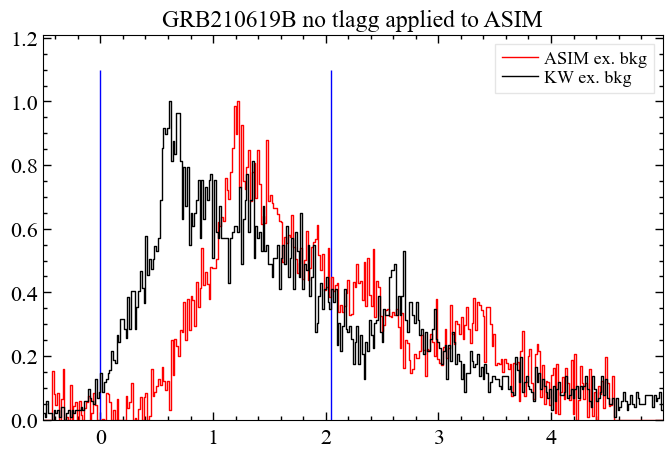

In [32]:
tus_asim = df_asim['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
j_a_stop = np.searchsorted(asim_edges, 0.4)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:j_a_stop]), 0) #removing bkg from ASIM

plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='r')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,2.048],ymin=0,ymax=1.1,color='blue')
#plt.xlim(left=0.1, right=2)
plt.ylim(bottom=0)
plt.legend()
plt.title("GRB210619B no tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

# FERMI
    - first using ToF to shift FERMI LC into KW ref. frame. Superimposing LCs to verify.
    - Applied CC func., but 16 ms resolution was too low; NEED 2 ms!

In [105]:
GRB_id = "GRB210619B"
bn='bn210619999' # GRB id for Fermi
data_dir = path_FERMI_dir + "/" + bn +"/" #setting path to data dir
unit='all' #which units to use. which filenames to open

fn_trigdat = data_dir+'glg_trigdat_'+unit+'_'+bn+'_v01.fit' #check of its a different v01.fit

trigdat = Trigdat.open(fn_trigdat)
print(trigdat)
print(trigdat.trigtime)


# Once extracted, it has the full capabilities of the [```Ctime```](./PhaiiData.ipynb) class.  You can also retrieve the sum of the detectors:
# the triggered detectors
trig_dets = trigdat.triggered_detectors
print(trig_dets)

grb_ra, grb_dec = 319.7161, 33.8495  #put in manually

all_dets=np.array(['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','na','nb','b0','b1'])
point_dets = np.zeros(shape=(all_dets.size,2))
for i in range(all_dets.size):
    point_dets[i,:] = trigdat.detector_pointing(all_dets[i], trigdat.trigtime)

#Q: Finding out where each detector is pointing and storing in a 14x2 matrix?
# ra, dec?

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Calculate the angular separation for all detectors
from astropy.coordinates.angle_utilities import angular_separation

ang_sep = np.zeros(all_dets.size)
for i in range(all_dets.size):
    ang_sep[i] = np.rad2deg(angular_separation(np.deg2rad(point_dets[i,0]),np.deg2rad(point_dets[i,1]),np.deg2rad(grb_ra),np.deg2rad(grb_dec)))
    
#Q: finding anugalar seperation in degrees from where each detector is pointing and the location of the burst?
#-->storting in ang_sep 14x1 matrix

# Print dets with increasing angular separation from the GRB position
idx_sort_angsep = np.argsort(ang_sep) #sorting in increasing order
for i in idx_sort_angsep:
    print(all_dets[i],round(ang_sep[i],3))
    
#print(all_dets[idx_sort_angsep]) #sorting
#print(ang_sep[idx_sort_angsep]) #sorting
# Best illuminated units: n7, n6

#The detectors nearest to the burst are listed first. If the degree is more than 60 deg, be careful to use the response function


glg_trigdat_all_bn210619999_v01.fit
645839970.604186
['n2', 'n3', 'n4', 'n7', 'n8']
n8 25.951
n4 50.99
n7 68.489
nb 71.935
b1 75.565
n3 83.874
n6 90.944
b0 104.435
n5 107.661
n9 124.022
n0 126.455
na 128.196
n1 144.321
n2 155.105


In [15]:
print(f'lat {np.round(trigdat.get_latitude(645839970.604186),4)}')
print(f'lon: {np.round(trigdat.get_longitude(645839970.604186),4)}')
print(f'alt: {np.round(trigdat.get_altitude(645839970.604186)/1e3,4)} km')

lat 24.3191
lon: 277.5315
alt: 534.4315 km


In [116]:
unit = all_dets[idx_sort_angsep][4] #for selecting the detector that are have the lowest incident angle to the GRB
#unit = trig_dets[1] #unit of the first trigger detector. What unit is this?
print(unit)

fn_tte = data_dir+'glg_tte_'+unit+'_'+bn+'_v00.fit'
fn_rsp = data_dir+'glg_cspec_'+unit+'_'+bn+'_v01.rsp2' #make sure version is correct. (ls *.rsp2) use cspec because it have the same number of energy channels

b1


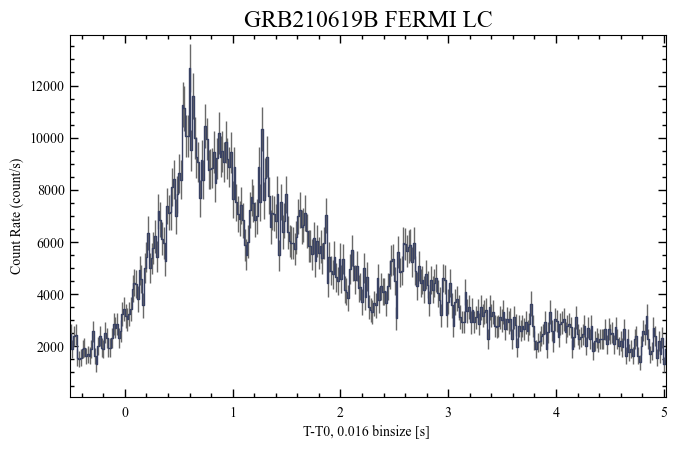

In [117]:
# open a TTE file
tte = TTE.open(fn_tte)

#bin_by_time is defined in imports. now have the spectra for each bin 
phaii = tte.to_phaii(bin_by_time,binsize,time_ref=0.0) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350,1e5)
lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)
lcplot.xlim = (bins[0],bins[-1])
lcplot.ax.set_title(f'GRB210619B FERMI LC')
lcplot.ax.set_xlabel(f'T-T0, {binsize} binsize [s] ')
#plt.savefig(fname='/Users/andreas/phys/master/GRB/pyplots/GRB211211A_FERMI_LC.png')
plt.show()

# CC

## KW / FERMI cc

In [36]:
# applying the ToF
KW_T0 = datetime.fromisoformat('2021-06-19T23:59:28.157')
tof_kw_asim = -2.6183 # reached KW first
tof_asim_fermi = 0.0227 #reaced ISS first
fermi_shift_T0 = KW_T0 + timedelta(seconds=tof_kw_asim+tof_asim_fermi)
print(fermi_shift_T0)
fermi_T0 = datetime.fromisoformat('2021-06-19T23:59:25.604') # calculated from MET = 645839970.604186 
print(fermi_T0)
tlagg_fermi = (fermi_T0-fermi_shift_T0).total_seconds()
print(f'fermi_tlagg estimation: {tlagg_fermi} s. apply to tus_fermi')

2021-06-19 23:59:25.561400
2021-06-19 23:59:25.604000
fermi_tlagg estimation: 0.0426 s. apply to tus_fermi


In [37]:
# fermi bkg estimation
tus_fermi = tte.data.time

i_bkg,j_bkg = find_nearest(tus_fermi,-80),find_nearest(tus_fermi,-20)
tus_fermi_bkg = tus_fermi[i_bkg:j_bkg]

fermi_bkg_c,fermi_bkg_e = np.histogram(tus_fermi_bkg,bins=np.arange(min(tus_fermi_bkg),max(tus_fermi_bkg)+binsize,binsize))
fermi_mean_bkg = np.round(np.mean(fermi_bkg_c),4)
print(fermi_mean_bkg)

38.0011


In [38]:
#fermi
tus_fermi = tte.data.time + tlagg_fermi
fermi_ix,fermi_jx = np.searchsorted(tus_fermi,bins[0]), np.searchsorted(tus_fermi,bins[-1])
tus_fermi = tus_fermi[fermi_ix:fermi_jx]
fermi_counts,fermi_edges = np.histogram(tus_fermi,bins=bins)
fermi_counts = np.maximum(fermi_counts - fermi_mean_bkg, 0)

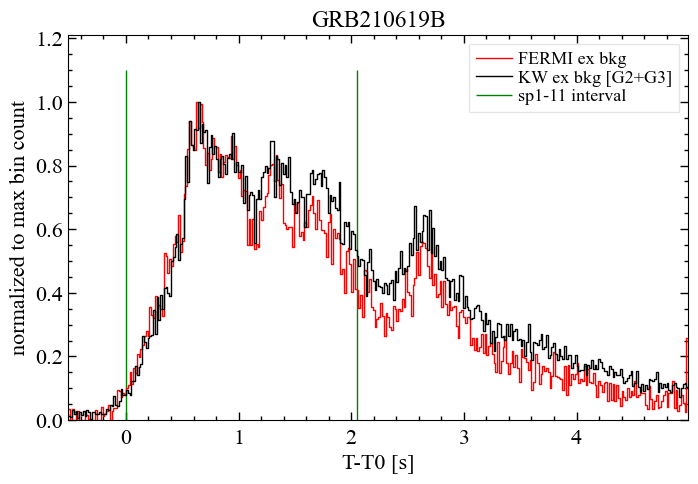

In [40]:
plt.step(x=bins[:-1],y=fermi_counts/max(fermi_counts),c='r',where='pre',label='FERMI ex bkg')
plt.step(x=bins[:-1],y=(G2+G3)/max(G2+G3),c='black',where='pre',label='KW ex bkg [G2+G3]')
plt.vlines(x=[0.0,2.048],ymin=0,ymax=1.1,color='green',label='sp1-11 interval')
plt.ylim(bottom=0.0)
plt.legend()
plt.title('GRB210619B')
plt.xlabel('T-T0 [s]')
plt.ylabel('normalized to max bin count')
plt.show()

## KW / ASIM cc

In [41]:
#calculating tlagg_approx from ToF

KW_T0 = datetime.fromisoformat('2021-06-19T23:59:28.157')
tof_kw_asim = -2.6183 # reached KW first

asim_T0_approx = KW_T0 + timedelta(seconds=tof_kw_asim)

asim_T0 = datetime.fromisoformat('2021-06-19T23:59:25.494265')

tlagg_approx_asim = (asim_T0-asim_T0_approx).total_seconds()
print(asim_T0)
print(asim_T0_approx)
print(f'asim tlagg estimation: {tlagg_approx_asim} s. apply to tus_asim')

2021-06-19 23:59:25.494265
2021-06-19 23:59:25.538700
asim tlagg estimation: -0.044435 s. apply to tus_asim


In [42]:
tlagg_approx_asim = -0.6

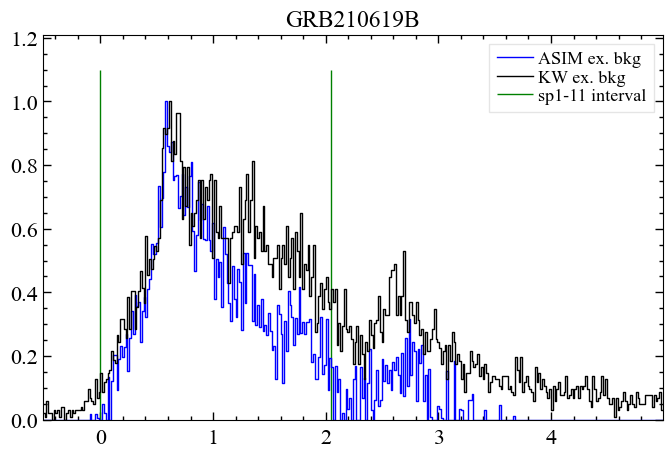

In [45]:
tus_asim = df_asim['tus'].to_numpy() + tlagg_approx_asim

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
asim_jx = np.searchsorted(asim_edges, 0.4)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:asim_jx]), 0)

plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,2.048],ymin=0,ymax=1.1,label='sp1-11 interval',color='g')
#plt.xlim(left=0.1, right=2)
plt.ylim(bottom=0.0)
plt.title("GRB210619B")
plt.legend()
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [46]:
asim_lc = LC(time=asim_edges[:-1]+binsize/2,counts=asim_counts,skip_checks=True)
kw_lc = LC(time=bins[:-1]+binsize/2,counts=G3,skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

tlagg_asim: 0.016000032424926758


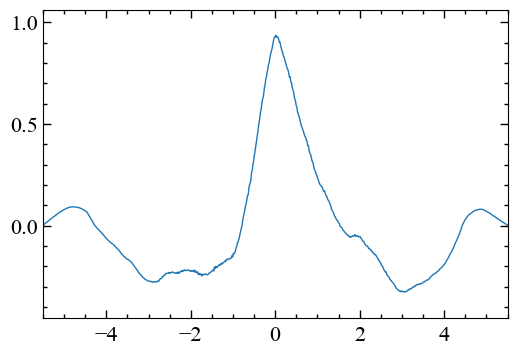

In [47]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg_asim = CC_kw_asim.time_shift
print(f'tlagg_asim: {tlagg_asim}')
CC_kw_asim.plot()
plt.show()

In [48]:
print(np.round(tlagg_approx_asim + tlagg_asim,3))

-0.584


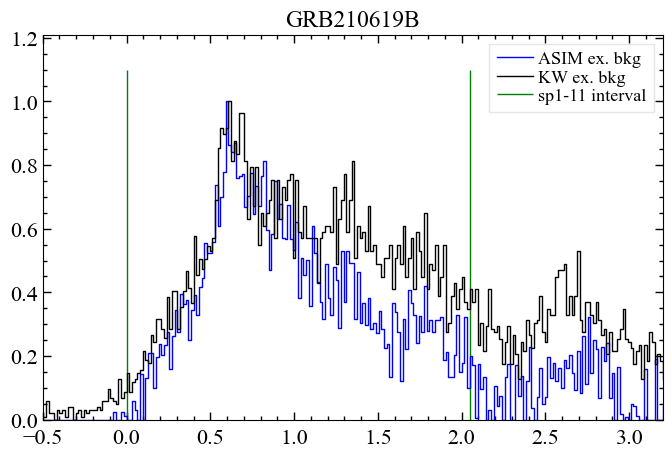

In [53]:
tus_asim = df_asim['tus'].to_numpy() + np.round(tlagg_approx_asim + tlagg_asim,3)

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
asim_jx = np.searchsorted(asim_edges, 0.4)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:asim_jx]), 0)

plt.step(x=bins[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=[0.0,2.048],ymin=0,ymax=1.1,label='sp1-11 interval',color='g')
plt.xlim(left=-0.5, right=3.2)
plt.ylim(bottom=0.0)
plt.title("GRB210619B")
plt.legend()
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

# SUPERPLOT
    -REMAKE THIS PLOT WITH SP1_11 INTERVAL
    -USE THE NEW DATA FROM ANDREY! interesting to see if the counts differ

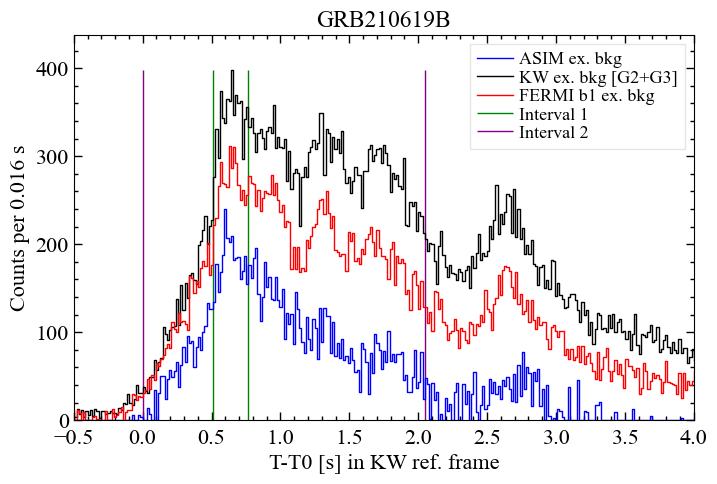

In [59]:
plt.step(x=bins[:-1], y=asim_counts, where='pre', label='ASIM ex. bkg',c='blue')
plt.step(x=bins[:-1],y=G2+G3,where='pre',label='KW ex. bkg [G2+G3]',c='black')
plt.step(x=bins[:-1],y=fermi_counts,where='pre',label=f'FERMI {unit} ex. bkg',c='r')
plt.vlines(x=[0.512,0.768],ymin=0,ymax=max(G2+G3),color='green',label='Interval 1')
plt.vlines(x=[0.0,2.048],ymin=0,ymax=max(G2+G3),color='purple',label='Interval 2')
plt.ylim(bottom=0.0)
plt.xlim(left=-0.5, right=4)
plt.legend(loc='best')
plt.ylabel(f'Counts per {binsize} s')
plt.xlabel('T-T0 [s] in KW ref. frame')
plt.title('GRB210619B')
plt.savefig('GRB210619B_superplot.png', dpi=350, bbox_inches='tight', format='png')
plt.show()

# Extraction of FITS files

## ASIM extraction

In [60]:
df_asim['tus'] += np.round(tlagg_approx_asim + tlagg_asim,3)
asim_T0 += timedelta(seconds=np.round(tlagg_approx_asim + tlagg_asim,3))
print(asim_T0)
df_asim.head()

2021-06-19 23:59:24.910265


,tus,dau,det,typ,erg,adr,keV,st,dt,flag
0,-1.009385,3,2,0,34,8,972.7597,0.945519,0.0,False
1,-1.009071,2,2,0,788,5,12185.5714,19.000000,0.0,False
2,-1.009071,2,3,0,1595,6,28045.9063,23.000000,108.0,False
3,-1.009071,3,2,0,389,8,10483.0308,13.386425,314.0,False
4,-1.008997,3,3,0,16,9,406.3742,0.000000,74.0,False


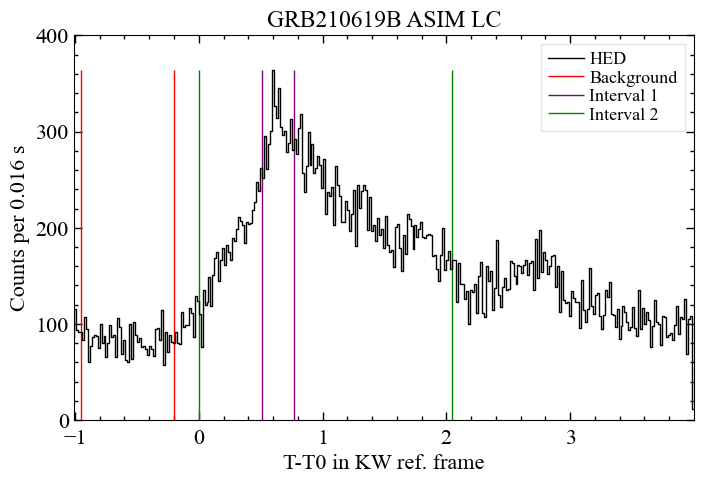

In [78]:
tus_asim = df_asim['tus'].to_numpy()
asim_counts, asim_edges = np.histogram(tus_asim, bins=np.arange(min(tus_asim),4+binsize,binsize))
plt.step(x=asim_edges[:-1],y=asim_counts,where='pre',label='HED',c='black')
plt.vlines(x=[-0.95,-0.2],ymin=0,ymax=max(asim_counts),color='red',label='Background')
plt.vlines(x=[0.512,0.768],ymin=0,ymax=max(asim_counts),color='purple',label='Interval 1')
plt.vlines(x=[0.0,2.048],ymin=0,ymax=max(asim_counts),color='green',label='Interval 2')
plt.ylim(bottom=0.0)
plt.legend()
plt.title('GRB210619B ASIM LC')
plt.xlabel('T-T0 in KW ref. frame')
plt.ylabel(f'Counts per {binsize} s')
#plt.savefig('GRB210619B_ASIM_LC.png',dpi=350,format='png')
plt.show()

In [80]:
df_keV_interval1 = keV_hist(df=df_asim,time_interval=(0.512,0.768),keV_interval='max',convert_seconds=False)
df_keV_interval2 = keV_hist(df=df_asim,time_interval=(0.0,2.048),keV_interval='max',convert_seconds=False)
df_keV_bak = keV_hist(df=df_asim,time_interval=(-0.95,-0.2),keV_interval='max',convert_seconds=False)

initial len: (91255, 91255)
Start/Stop (0.512018, 0.7679710000000001)
len kev 4782
len tus 4782
mean: 119.55
Energies binned!
initial len: (91255, 91255)
Start/Stop (7.6000000000076e-05, 2.0479819999999997)
len kev 27643
len tus 27643
mean: 691.025
Energies binned!
initial len: (91255, 91255)
Start/Stop (-0.949839, -0.200007)
len kev 3883
len tus 3883
mean: 97.075
Energies binned!


In [99]:
bin_lo = df_keV_interval2['bins_keV'].to_numpy()[:-1]
bin_hi = df_keV_interval2['bins_keV'].to_numpy()[1:]
counts = df_keV_interval2['counts'].to_numpy()[1:]
err = df_keV_interval2['poisson_error_counts'].to_numpy()[1:]
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [83]:
print('Exposure: ',np.round(0.7679710000000001-0.512018,3))
print(asim_T0)

Exposure:  0.256
2021-06-19 23:59:24.910265


### PHA

In [98]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-06-19T23:59:24.910','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [2.048,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [2.048,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB210619B','Name of the observed object'], #<str> 
    'RA_OBJ': [319.716,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [33.850,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB210619B.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB210619B.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB210619B_Int2.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [100]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK

In [88]:
0.949839-0.200007

0.749832

In [93]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-06-19T23:59:24.910','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.949839,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.200007,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [0.749832,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB211211A','Name of the observed object'], #<str> 
    'RA_OBJ': [319.716,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [33.850,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB211211A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

In [101]:
bak_counts = df_keV_bak['counts'].to_numpy()[1:]
bak_err = df_keV_bak['poisson_error_counts'].to_numpy()[1:]

generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP
    -generate new respone for each pha file, since exposure is varying (?)

In [102]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2021-06-19T23:59:24.910','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [2.048,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [2.048,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB210619B','Name of the observed object'], #<str> 
    'RA_OBJ': [319.716,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [33.850,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB210619B.rsp','RSP filename'] #<str>  ('example.pha')
}

In [96]:
theta,phi = 135.591, -138.783
#drm_path = '/Home/siv30/wad005/master/HED_DRM/data'
drmfname = 'HED_drm_mats_135.00_-135.00.txt' #find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_135.00_-135.00.txt


In [103]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=theta,phi=phi)

## FERMI extraction
    -verified that TRIGTIME changed in new_tte.header


All MAC paths are set!


<Figure size 800x500 with 0 Axes>


All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
FERMI functions loaded successfully!
tte shifted by 0.0426
new TTE object created
fitting background...


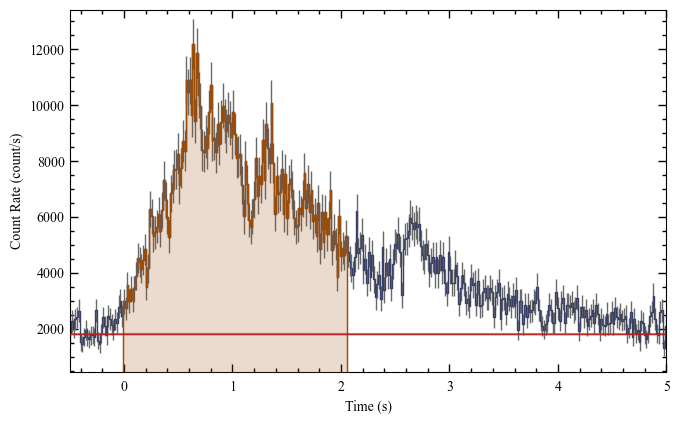

Normalised residuals: mean= 0.000524  std= 1.03
NormaltestResult(statistic=109.43073656005225, pvalue=1.7274977113599013e-24)


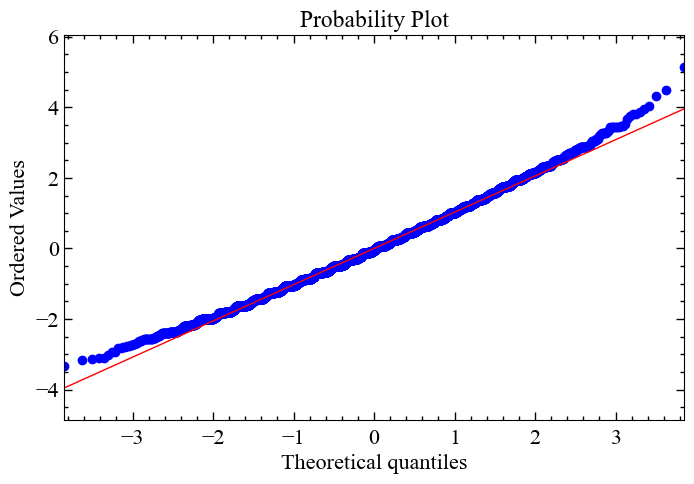

In [118]:
#need to create a new tte object, which is shifted by tlagg_kw_fermi
%run /Users/andreas/phys/master/GRB/xspec/FERMI/fermi_functions.ipynb

new_tte = createNewTTE(oldTTEObj=tte,tlagg=tlagg_fermi,binsize=binsize,unit=unit,obj='GRB210619B',grb_ra=grb_ra,grb_dec=grb_dec)
phaii = new_tte.to_phaii(bin_by_time, binsize) #puls height amplitude of second type ii. i: sum along columns, ii: for all channels

erange = (350, 1e5) #usually advised lower range. Standard passband
lc_data = phaii.to_lightcurve(energy_range=erange)

print('fitting background...')
bkgd_times = [(-200.0, -50.0), (150,250)] # where to extract the background
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=2) #increase order to 2 when you have a large interval 

bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
src_time = (0.0,2.048)
view_range = (-0.5,5)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)
lcplot.xlim = view_range
lcplot.add_selection(src_lc)
plt.show()

# Define normalised residuals and test their compatibility with a standardized normal distribution
isel = np.where( ((lc_data.centroids>bkgd_times[0][0]) & (lc_data.centroids<bkgd_times[0][1])) | ((lc_data.centroids>bkgd_times[1][0]) & (lc_data.centroids<bkgd_times[1][1])) )[0]
isel_bkg = np.where( ((lc_bkgd.time_centroids>bkgd_times[0][0]) & (lc_bkgd.time_centroids<bkgd_times[0][1])) | ((lc_bkgd.time_centroids>bkgd_times[1][0]) & (lc_bkgd.time_centroids<bkgd_times[1][1])) )[0]
if np.all(isel == isel_bkg):
    norm_res = (lc_data.counts[isel]-lc_bkgd.counts[isel_bkg])/np.sqrt(lc_bkgd.counts[isel_bkg])
    print("Normalised residuals: mean= {:.3g}  std= {:.3g}".format(norm_res.mean(),norm_res.std()))
   # QQ plot to test normality
    import pylab 
    import scipy.stats as stats
    plt.cla()
    stats.probplot(norm_res, dist="norm",plot=pylab)
    from scipy.stats import normaltest
    print(normaltest(norm_res))
    plt.show()
#mu=0 std= 1 good, make sure the red line is not far frow the blue scatter plots

In [119]:
GRB_id = 'FERMI_GRB210619B'
src_time = (0.0,2.048)
pha = new_tte.to_pha(time_ranges=src_time)
# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

# So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
# ```python
fn_spectral = GRB_id + "_" + unit
bak.write('./', filename=fn_spectral+'.bak')
pha.write('./', filename=fn_spectral+'.pha', backfile=fn_spectral+'.bak')

# Read RSP function
rsp = RSP.open(fn_rsp)
# and interpolate response files to get DRMs at center of the source window
rsp_interp = rsp.interpolate(pha.tcent) #tcent central time of spectrum. interpolating the rsp at the time we specified

# Write response file
rsp_interp.write('./', filename=fn_spectral+'.rsp')

# It's advisable to set the RESPFILE keyword properly in the PHA file:
print("fparkey " + str(fn_spectral)+ ".rsp " + str(fn_spectral) + ".pha+2 RESPFILE")


fparkey FERMI_GRB210619B_b1.rsp FERMI_GRB210619B_b1.pha+2 RESPFILE
